<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Libraries</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from skorch import NeuralNetClassifier


<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Goal</div>

The aim is to develop a model that can predict which customers are likely to churn. 

<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">The Data</div>

**Source:** https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

The data set contains the following columns:

**CustomerId:** A unique identifier for each customer.  
**Surname:** The last name of the customer.  
**CreditScore:** The customer's credit score, which reflects creditworthiness.  
**Geography:** The country in which the customer is located.  
**Gender:** The gender of the customer.  
**Age:** The age of the customer.  
**Tenure:** The number of years the customer is at the bank.  
**Balance:** The customer's account balance.  
**NumOfProducts:** The number of products the customer has at the bank.  
**HasCrCard:** An indicator of whether the customer has a credit card (1 = Yes, 0 = No).  
**IsActiveMember:** An indicator of whether the customer is an active member (1 = Yes, 0 = No).  
**EstimatedSalary:** The estimated salary of the customer.  
**Exited:** An indicator if a customer has left the bank (1 = Yes, 0 = No). 

Both demographic and financial aspects of customers allow a detailed analysis of factors that could contribute to customer churn. In particular, features such as credit score, age, number of products and customer engagement can be used to identify patterns and correlations that indicate an increased risk of churn.

<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Initial Data Analysis</div>

In [2]:
churn_df = pd.read_csv('churn.csv')
display(churn_df.head())
print("Anzahl der Zeilen und Spalten: ", churn_df.shape)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Anzahl der Zeilen und Spalten:  (10000, 14)


In [3]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


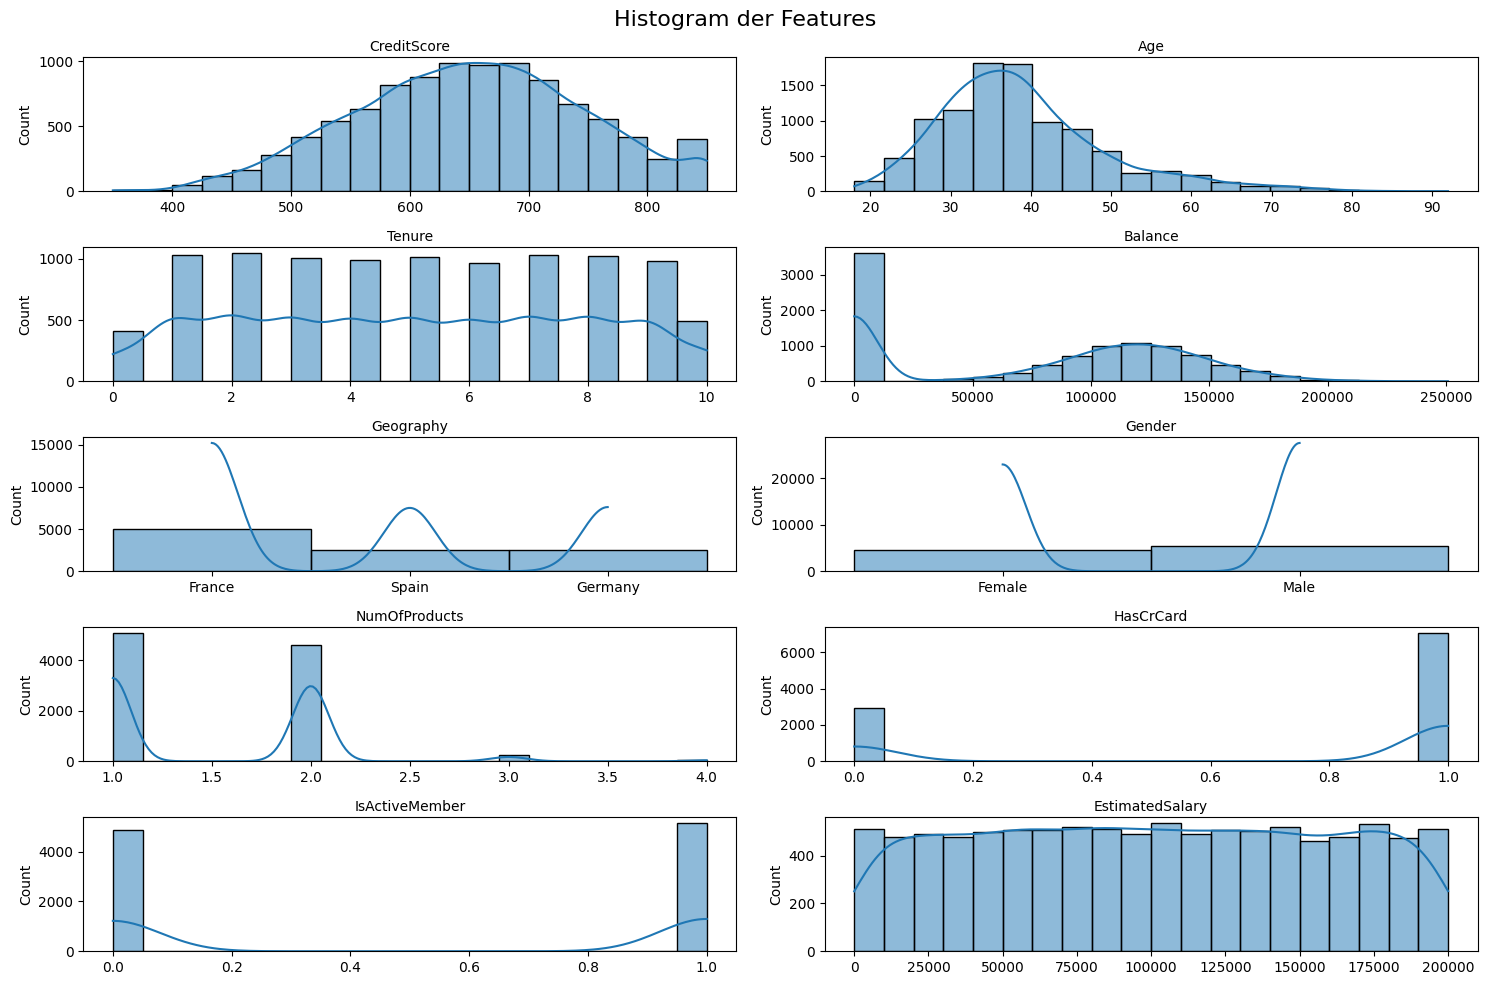

In [4]:
# Features
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'Geography', 'Gender', 'NumOfProducts',	'HasCrCard', 'IsActiveMember',	'EstimatedSalary',]

# Rasterplot mit 5 Zeilen und 3 Spalten
fig, axes = plt.subplots(5, 2, figsize=(15, 10))

# Iteriert über die Features und erstellt die Histogramme in Subplots
for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.histplot(data=churn_df, x=feature, ax=axes[row, col], bins=20, kde=True)
    axes[row, col].xaxis.set_label_position('top')

# Stellt sicher, dass die Diagramme nicht überlappen
plt.suptitle('Histogram der Features', fontsize=16)
plt.tight_layout()

plt.show()

In [5]:
def plot_target_distribution(y, title='Verteilung erhaltener/abgewandeter Kunden'):
    
    """
    Plots the distribution of the target variable in the given data..
    """
    
    auswertung = y.value_counts(normalize=True).plot(kind='bar', color=['green', 'red'], figsize=(8, 5),
                                                     title=title)
    for i, count in enumerate(auswertung.patches): 
        plt.text(count.get_x() + count.get_width() / 2, count.get_height() + 0.01,  
                 f"{round(count.get_height() * 100, 2)}%", ha='center', color='black', fontweight='bold')
    plt.xlabel('Abgewandert (0 = Nein, 1 = Ja)')
    plt.ylabel('Prozentuale Anzahl der Kunden')
    plt.show()

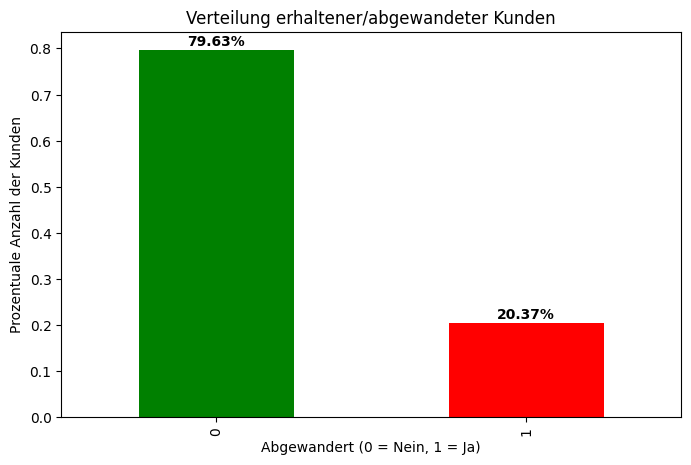

In [6]:
plot_target_distribution(churn_df['Exited'], title='Verteilung erhaltener/abgewandeter Kunden')

<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Explorative Data Analysis</div>

Customers who use more than 2 products at Global Bank are more likely to migrate. This could indicate that more intensive users of banking services may have higher expectations and are more likely to leave the bank if they are dissatisfied. However, the number of customers who use more than two products at Global Bank is very small (~3.2%) and therefore not necessarily generalizable or significant.

In [7]:
# identifiziert fehlende Werte
print("Anzahl fehlender Werte im Datensatz: ",  churn_df.isna().sum())

# identifiziert Duplizierte Werte
print("Anzahl duplizierter Werte im Datensatz: ", churn_df.duplicated().sum())

Anzahl fehlender Werte im Datensatz:  RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Anzahl duplizierter Werte im Datensatz:  0


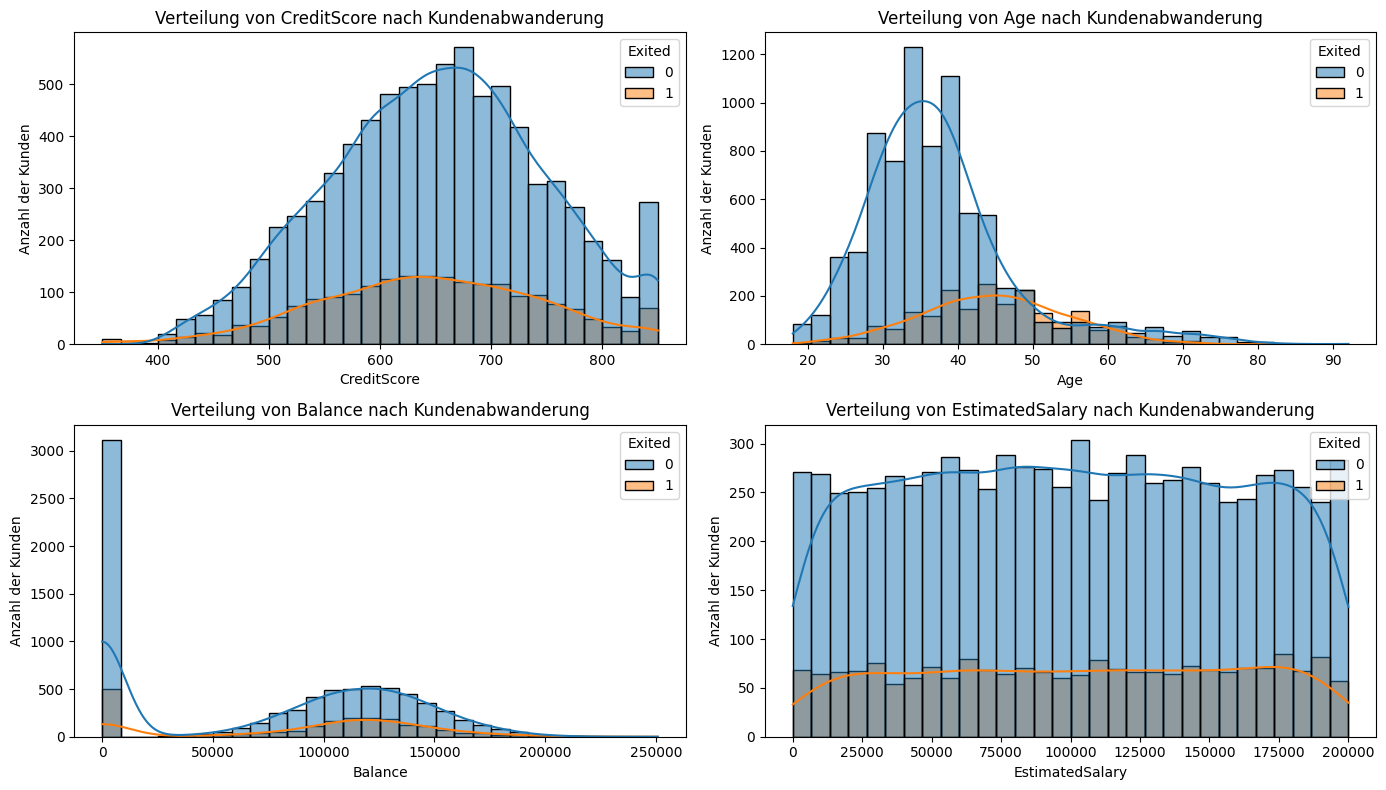

In [8]:
continous_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

# Rasterplots mit 2 Zeilen und 2 Spalten
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Iteriert über continous features und erstellt Histogramme in Subplots
for i, feature in enumerate(continous_features):
    row = i // 2
    col = i % 2
    sns.histplot(data=churn_df, x=feature, hue='Exited', kde=True, bins=30, ax=axes[row, col])
    axes[row, col].set_title(f'Verteilung von {feature} nach Kundenabwanderung')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Anzahl der Kunden')

plt.tight_layout()
plt.show()


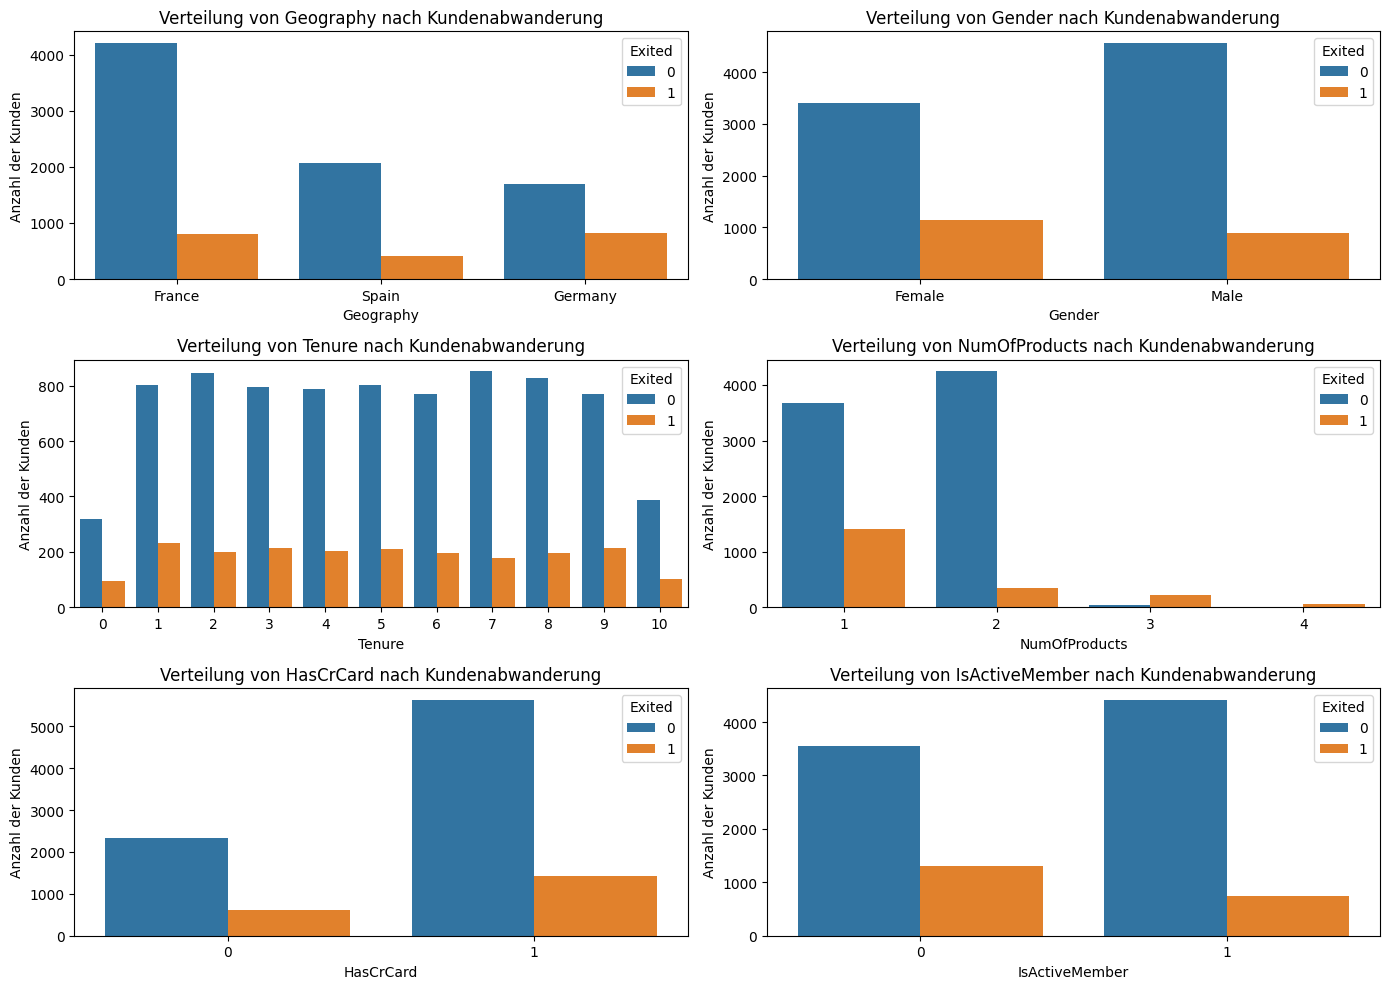

In [9]:
discrete_features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

# Rasterplots mit 3 Zeilen und 2 Spalten
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

for i, feature in enumerate(discrete_features):
    row = i // 2
    col = i % 2
    sns.countplot(x=feature, hue='Exited', data=churn_df, ax=axes[row, col])
    axes[row, col].set_title(f'Verteilung von {feature} nach Kundenabwanderung')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Anzahl der Kunden')

plt.tight_layout()
plt.show()

#### Preprocessing

The split between training and test data was initially chosen at a ratio of 90% to 10%. This high proportion of training data is necessary because the class distribution of the target variable is highly unbalanced.

In [10]:
# Entfernen von für die Analyse unbedeutsamer Features
churn_df = churn_df.drop(['RowNumber','CustomerId', 'Surname'], axis=1)

# One-Hot-Encoding für kategorische Features
churn_df = pd.get_dummies(churn_df, columns=['Geography', 'Gender'], drop_first=True)


In [11]:
# Bestimmen der Features und der Zielvariable
X = churn_df.drop('Exited', axis=1)
y = churn_df['Exited']

# Daten in Training und Test aufteilen (90% Training, 10% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Überprüfen der Aufteilung
print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")

Train set: 9000, Test set: 1000


In [12]:
# Min-Max-Scaler für die Skalierung der Features
scaler = MinMaxScaler()

# Skalieren der Features für Training und Test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame mit den skalierten Features für Training und Test
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

Neue Klassenverteilung nach Undersampling: Exited
0    1833
1    1833
Name: count, dtype: int64


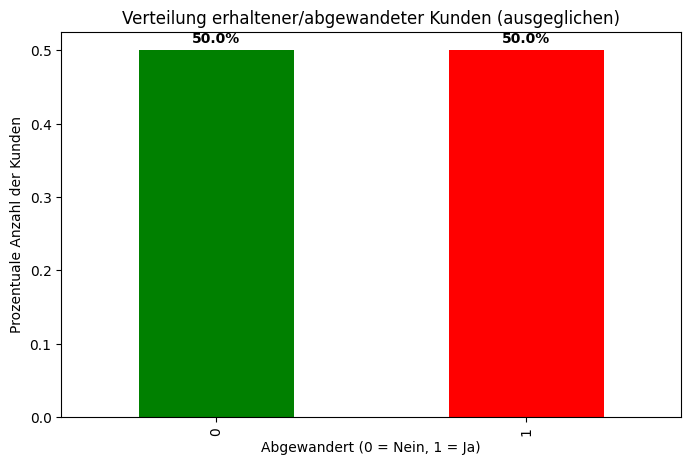

In [13]:
undersampler = RandomUnderSampler(random_state=42)

# Undersampler auf die Trainingsdaten anwenden
X_train_res, y_train_res = undersampler.fit_resample(X_train_scaled_df, y_train)

# Überprüfen der neuen Klassenverteilung
print(f"Neue Klassenverteilung nach Undersampling: {y_train_res.value_counts()}")

# Plot der neuen Klassenverteilung
plot_target_distribution(y_train_res, title='Verteilung erhaltener/abgewandeter Kunden (ausgeglichen)')


In [14]:
# Ausgeglichene Trainingsdaten in Training und Validation aufteilen
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42, stratify=y_train_res)

# Überprüfen der Aufteilung
print(f"Final Training set: {len(X_train_final)}")
print(f"Final Validation set: {len(X_val)}")
print(f"Final Test set: {len(X_test_scaled_df)}")


Final Training set: 2932
Final Validation set: 734
Final Test set: 1000


<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Baselines</div>

In [15]:
# Funktion zur Berechnung der Metriken
def calculate_metrics(y_real, y_predict, algo):
    accuracy = accuracy_score(y_real, y_predict)
    precision = precision_score(y_real, y_predict)
    recall = recall_score(y_real, y_predict)
    f1 = f1_score(y_real, y_predict)
    auc = roc_auc_score(y_real, y_predict)

    return {'algorithm':algo,'accuracy':accuracy, 'precision':precision, 'recall':recall, 'f1_score':f1, 'roc_auc':auc}

#### Dummy Classifier

In [16]:
# DummyClassifier 
baseline_model = DummyClassifier(strategy='uniform', random_state=42)
baseline_model.fit(X_train_final, y_train_final)


y_pred_baseline = baseline_model.predict(X_test_scaled_df)

# DataFrame für die Metriken erstellen
metrics_df = pd.DataFrame(columns=('algorithm','accuracy','precision','recall','f1_score','roc_auc'))

# Metriken für den DummyClassifier berechnen
baseline_metrics = calculate_metrics(y_test, y_pred_baseline, 'DummyClassifier')
dummy_metrics_df = pd.DataFrame([baseline_metrics])
metrics_df = pd.concat([metrics_df, dummy_metrics_df], ignore_index=True)

display(metrics_df)

,algorithm,accuracy,precision,recall,f1_score,roc_auc
0,DummyClassifier,0.51,0.219608,0.54902,0.313725,0.52451


In [17]:
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       0.81      0.50      0.62       796
           1       0.22      0.55      0.31       204

    accuracy                           0.51      1000
   macro avg       0.52      0.52      0.47      1000
weighted avg       0.69      0.51      0.56      1000



#### Support Vector Machine

In [18]:
# SVM trainieren 
svm = SVC(kernel='linear', random_state=42) 
svm.fit(X_train_final, y_train_final) 
y_pred_svm = svm.predict(X_test_scaled_df) 

# Metriken für SVM berechnen
svm_metrics = calculate_metrics(y_test, y_pred_svm, 'SVM') 

# DataFrame für die Metriken erstellen und mit dem bestehenden DataFrame zusammenführen
svm_metrics_df = pd.DataFrame([svm_metrics])
metrics_df = pd.concat([metrics_df, svm_metrics_df], ignore_index=True)

display(metrics_df)

,algorithm,accuracy,precision,recall,f1_score,roc_auc
0,DummyClassifier,0.510,0.219608,0.549020,0.313725,0.524510
1,SVM,0.709,0.381471,0.686275,0.490368,0.700549


In [19]:
print((classification_report(y_test, y_pred_svm)))

              precision    recall  f1-score   support

           0       0.90      0.71      0.80       796
           1       0.38      0.69      0.49       204

    accuracy                           0.71      1000
   macro avg       0.64      0.70      0.64      1000
weighted avg       0.79      0.71      0.73      1000



<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Deep Learning Experiments</div>

Two neural models were trained. In addition, an optimization was performed to determine the architecture of the neural model with the best performance.

In [20]:
X_train_tensor = torch.tensor(X_train_final.values, dtype=torch.float32)  # Eingabedaten für Training
y_train_tensor = torch.tensor(y_train_final.values, dtype=torch.float32)  # Zielwerte für Training
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)      # Eingabedaten für Validierung
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)      # Zielwerte für Validierung
X_test_tensor = torch.tensor(X_test_scaled_df.values, dtype=torch.float32)    # Eingabedaten für Test
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)    # Zielwerte für Test

#### Reproducability Function

In [21]:
def set_seeds(seed=42):
    
    random.seed(seed)                           # um Zufallszahlen reproduzierbar zu machen
    np.random.seed(seed)                        # Setzen des Seeds für NumPy
    torch.manual_seed(seed)                     # Setzen des Seeds für PyTorch
    torch.set_num_threads(1)                    # Setzen der Anzahl der Threads auf 1 für reproduzierbare Ergebnisse
    torch.backends.cudnn.deterministic = True   # Aktivieren von deterministischen Algorithmen in CuDNN
    torch.backends.cudnn.benchmark = False      # Deaktivieren von CuDNN-Benchmarking

#### Plot Training & Validiation loss

In [22]:
def plot_training_validation_loss(train_loss_csv, val_loss_csv, title, train_color='#3399FF', val_color='#00CC00'):
    """
    Plots training and validation loss from CSV files.
    """

    # csv-Dateien lesen
    training_loss = pd.read_csv(train_loss_csv)
    validation_loss = pd.read_csv(val_loss_csv)

    # Epoch als Index setzen
    training_loss.set_index('Step', inplace=True)
    validation_loss.set_index('Step', inplace=True)

    # DataFrames zusammenführen
    losses = training_loss.join(validation_loss, lsuffix='_train', rsuffix='_val')

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(losses.index, losses['Value_train'], label='Training Loss', color=train_color)
    plt.plot(losses.index, losses['Value_val'], label='Validation Loss', color=val_color)

    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

#### Train & Evaluation Function

During training, training and validation losses are calculated and logged in Tensorboard. Early Stopping is implemented, which stops the training if the validation loss does not improve over a certain number of epochs. 

In [23]:
def train_model(model, optimizer, criterion, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, patience):
    """
    Trainiert ein PyTorch-Modell mit Early Stopping und protokolliert den Verlauf mit TensorBoard.

    Args:
    - model (nn.Module): Das zu trainierende PyTorch-Modell.
    - optimizer (torch.optim.Optimizer): Der Optimizer für das Modell.
    - criterion (torch.nn.Module): Die Verlustfunktion.
    - X_train_tensor (torch.Tensor): Die Trainingsdaten (Features) als Tensor.
    - y_train_tensor (torch.Tensor): Die Trainingslabels als Tensor.
    - X_val_tensor (torch.Tensor): Die Validierungsdaten (Features) als Tensor.
    - y_val_tensor (torch.Tensor): Die Validierungslabels als Tensor.
    - num_epochs (int): Die Anzahl der Trainingsepochen.
    - patience (int): Die Anzahl der Epochen ohne Verbesserung, bevor das Training abgebrochen wird.

    Returns:
    - best_model (nn.Module): Das Modell mit den besten Validierungsverlusten.
    """

    # Seeds für die Reproduzierbarkeit
    set_seeds()                                                         
    model.train()  
    
    # Initialisiert TensorBoard Writer
    writer = SummaryWriter()

    # Initialisiert Variablen für das beste Modell und den besten Validierungsverlust
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):  

        # Vorwärtsdurchlauf und Optimierung der Trainingsdaten
        optimizer.zero_grad()
        outputs_train = model(X_train_tensor)
        loss_train = criterion(outputs_train, y_train_tensor.view(-1, 1))
        loss_train.backward()
        optimizer.step()
        
        # Berechnung des Verlusts für die Validierungsdaten
        with torch.no_grad():
            outputs_val = model(X_val_tensor)
            loss_val = criterion(outputs_val, y_val_tensor.view(-1, 1))
        
        # Ausgabe für 10% aller Epochen
        if num_epochs <= 10:
            print_every = 1
        else:
            print_every = max(1, num_epochs // 10)
        
        # TensorBoard Logging
        writer.add_scalars('losses', {'train loss': loss_train.item(), 'val loss': loss_val.item()}, epoch)

        # Early Stopping
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            epochs_no_improve = 0
            best_model = copy.deepcopy(model.state_dict())  # Kopiert das beste Modell
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print(f"Early stopping after {epoch+1} epochs")
            break
        
        # Ausgabe für Epochen
        if (epoch + 1) % print_every == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")
    
    # TensorBoard Writer schließen
    writer.close()
    
    return best_model


In [24]:
def evaluate_model(model, criterion, X_test_tensor, y_test_tensor, algo_name, best_model):
    
    model.load_state_dict(best_model)                                       # Lade den besten Modellzustand aus dem Speicher
    model.eval()                                                            # Setze das Modell in den Auswertungsmodus
    
    with torch.no_grad():
        outputs = model(X_test_tensor)   
        loss = criterion(outputs, y_test_tensor.view(-1, 1)) 
        predicted = torch.round(outputs)
        
        # Berechnet Metriken mithilfe der calculate_metrics-Funktion
        metrics = calculate_metrics(y_test_tensor, predicted, algo_name)
        
    print(f"Test Loss: {loss.item():.4f}, Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}, ROC AUC: {metrics['roc_auc']:.4f}")
    return metrics


A MultiLayerPerceptron class was defined for the structure of the models, which comprises several fully connected layers and uses a sigmoid activation function in the output layer.

In [25]:
# MultiLayerPerceptron-Klasse
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation):
        super(MultiLayerPerceptron, self).__init__()
        layers = []
        prev_dim = input_dim

        for h_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, h_dim))
            prev_dim = h_dim

        layers.append(nn.Linear(prev_dim, 1))  # Output layer
        self.layers = nn.ModuleList(layers)
        self.activation = activation

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = torch.sigmoid(self.layers[-1](x))  # Sigmoid activation für Ausgabeschicht
        return x

#### Default Hyperparameters

nn.BCELoss() was selected as the loss function. The learning rate is set to 0.001, which is a common default value.  A maximum number of 1000 epochs was selected. For the patience, 5 epochs were defined.

In [26]:
criterion = nn.BCELoss()
learning_rate = 0.001
input_dim = X_train_tensor.shape[1]
num_epochs = 1000
patience = 5
set_seeds()

In order to investigate whether the model capacity has an influence on the performance of the models, two neural networks were trained that differ only in their capacity: the first model, “relu_3Layer”, has smaller layers (64, 32, 16), while the second model, “large_relu_3Layer”, has larger layers (256, 128, 64). ReLU (Rectified Linear Unit) was chosen as the activation function. 

#### 3 Layer Neural Net (64,32,16) with ReLu Activationfunction

In [27]:
relu_3L = MultiLayerPerceptron(input_dim=input_dim, 
                                  hidden_layers=[64, 32, 16], 
                                  activation=nn.ReLU())

optimizer_relu_3L = optim.Adam(relu_3L.parameters(), lr=learning_rate)

In [28]:
best_relu_3L = train_model(relu_3L, optimizer_relu_3L, criterion, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, patience)

Epoch 100/1000, Train Loss: 0.5655, Val Loss: 0.5602
Epoch 200/1000, Train Loss: 0.4543, Val Loss: 0.4652
Early stopping after 225 epochs


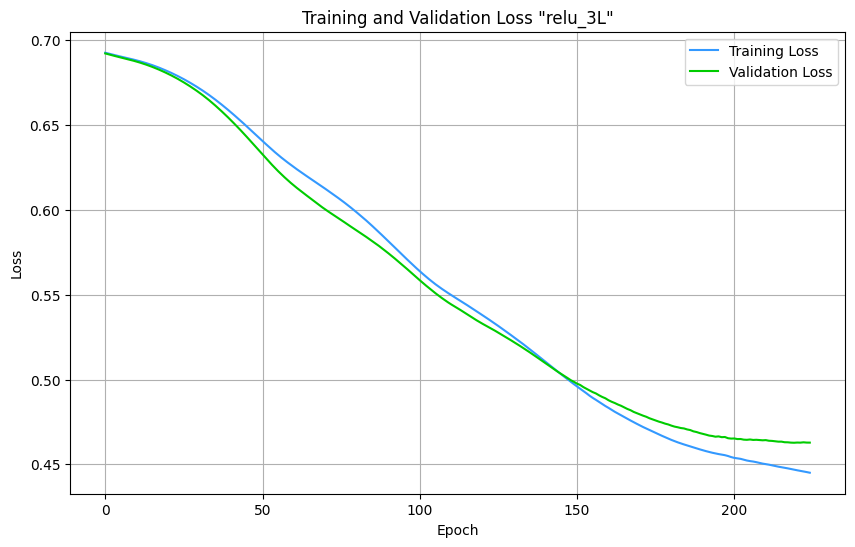

In [29]:
plot_training_validation_loss('train_loss_relu_3L.csv', 'val_loss_relu_3L.csv', 'Training and Validation Loss "relu_3L"')

In [30]:
metrics_relu_3L = evaluate_model(relu_3L, criterion, X_test_tensor, y_test_tensor, 'relu_3L', best_relu_3L)

Test Loss: 0.4958, Accuracy: 0.7470, Precision: 0.4318, Recall: 0.7598, F1 Score: 0.5506, ROC AUC: 0.7518


#### 3 Layer Neural Net (256,128,64) with ReLu Activationfunction

In [31]:
large_relu_3L = MultiLayerPerceptron(input_dim=input_dim, 
                              hidden_layers=[256, 128, 64], 
                              activation=nn.ReLU())

optimizer_large_relu_3L = optim.Adam(large_relu_3L.parameters(), lr=learning_rate)

In [32]:
best_model_large_relu_3L = train_model(large_relu_3L, optimizer_large_relu_3L, criterion, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, patience)

Epoch 100/1000, Train Loss: 0.4413, Val Loss: 0.4762
Early stopping after 111 epochs


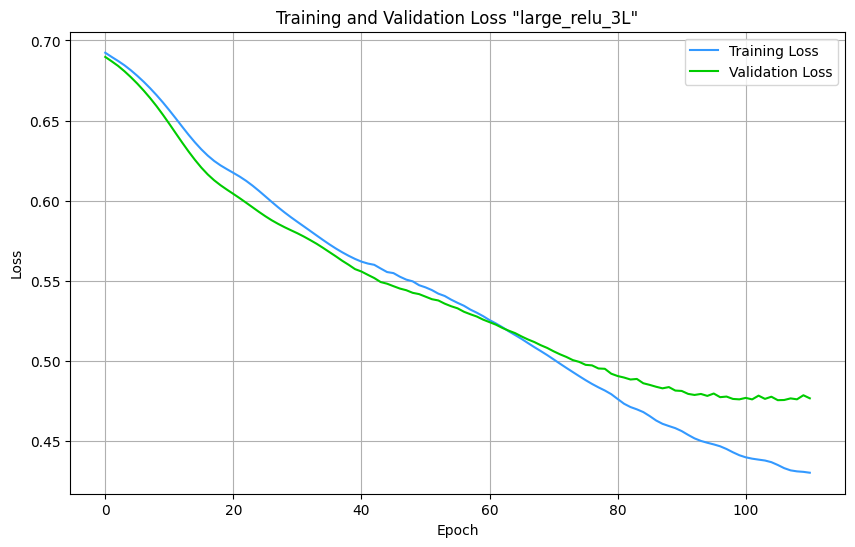

In [33]:
plot_training_validation_loss('train_loss_large_relu_3L.csv', 'val_loss_large_relu_3L.csv', 'Training and Validation Loss "large_relu_3L"')

In [34]:
metrics_large_relu_3L = evaluate_model(large_relu_3L, criterion, X_test_tensor, y_test_tensor, 'large_relu_3L', best_model_large_relu_3L)

Test Loss: 0.5105, Accuracy: 0.7540, Precision: 0.4407, Recall: 0.7647, F1 Score: 0.5591, ROC AUC: 0.7580


#### Optimization with GridSearch & Skorch NeuralNetClassifier

Hyperparameter optimization is performed using Grid Search in combination with a Skorch NeuralNetClassifier. 
The hyperparameter grid includes a variety of combinations of layer sizes (number and size of hidden layers) and activation functions.


In [35]:
def grid_search_optimization(X_train_tensor, y_train_tensor, input_dim):
    
    # Seeds für die Reproduzierbarkeit
    set_seeds() 

    # NeuralNetClassifier
    netclf = NeuralNetClassifier(
        module=MultiLayerPerceptron,
        module__input_dim=input_dim,
        max_epochs=num_epochs,  
        lr=learning_rate,
        optimizer=optim.Adam,
        criterion=criterion,
        iterator_train__shuffle=True,
        verbose=0,
    )
    
    
    # Hyperparameter Grid
    param_grid = {
        'module__hidden_layers': [
            [64, 32], [128, 64], [256, 128], [32, 16],                                   # Zwei hidden Layer
            [64, 32, 16], [128, 64, 32], [256, 128, 64], [32, 16, 8],                    # Drei hidden Layer
            [64, 32, 16, 8], [128, 64, 32, 16], [256, 128, 64, 32],                      # Vier hidden Layer
            [64, 32, 16, 8, 4], [128, 64, 32, 16, 8], [256, 128, 64, 32, 16]             # Fünf hidden Layer
        ],

    # Aktivierungsfunktionen
        'module__activation': [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Hardtanh(), 
            nn.LeakyReLU(), nn.ELU(),  nn.PReLU()
        ],  
    }
    
    # GridSearchCV
    classifier = GridSearchCV(netclf, param_grid, refit=True, cv=KFold(n_splits=3, shuffle=True, random_state=42),
                              scoring='recall', verbose=2, n_jobs=-1)
    classifier.fit(X_train_tensor, y_train_tensor)

    # Beste Hyperparameter anzeigen
    print("Beste Hyperparameter:", classifier.best_params_)
    print("Beste Score:", classifier.best_score_)
    
    
    return classifier.best_estimator_

In [36]:
best_model = grid_search_optimization(X_train_tensor, y_train_tensor.reshape(-1,1), input_dim= X_train_tensor.shape[1])

Fitting 3 folds for each of 98 candidates, totalling 294 fits
Beste Hyperparameter: {'module__activation': Sigmoid(), 'module__hidden_layers': [256, 128, 64, 32]}
Beste Score: 0.770804071281381


In [37]:
metrics_optimized_model = evaluate_model(best_model.module_, criterion, X_test_tensor, y_test_tensor, 'optimized_model', best_model.module_.state_dict())

Test Loss: 0.5580, Accuracy: 0.7210, Precision: 0.4069, Recall: 0.8039, F1 Score: 0.5404, ROC AUC: 0.7518


#### Evaluation

In [38]:
metrics_list = []

# Metriken in Liste speichern
metrics_list.append(metrics_relu_3L)
metrics_list.append(metrics_large_relu_3L)
metrics_list.append(metrics_optimized_model)

# DataFrame für die Metriken erstellen und mit dem bestehenden zusammenführen 
metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics_list)], ignore_index=True)

display(metrics_df)

,algorithm,accuracy,precision,recall,f1_score,roc_auc
0,DummyClassifier,0.510,0.219608,0.549020,0.313725,0.524510
1,SVM,0.709,0.381471,0.686275,0.490368,0.700549
2,relu_3L,0.747,0.431755,0.759804,0.550622,0.751761
3,large_relu_3L,0.754,0.440678,0.764706,0.559140,0.757981
4,optimized_model,0.721,0.406948,0.803922,0.540362,0.751835


- As expected, the DummyClassifier shows the worst performance with a recall of 0.549 and an accuracy of 0.510.  
- The SVM model performs better with a recall of 0.686 and an accuracy of 0.709.  
- The relu_3L model already shows good results with a recall of 0.760 and an accuracy of 0.747.  
- The large_relu_3L model increases these values slightly to a recall of 0.765 and an accuracy of 0.754.   
- The optimized model outperforms all previous models with a recall of 0.803. However, at 0.721, it has a lower accuracy than the other two neural models.

<style> .section-title {background-color: #2ecc71; color: white; border-radius: 15px; text-align: center; padding: 1px; font-size: 2em}</style>
<div class="section-title">Conclusion</div>

The results of the evaluation show that deeper neural models with optimized hyperparameters perform better than simpler models such as Support Vector Machine. Grid search optimization was successful with minimal improvement, showing that the model with activation function: **Sigmoid** and the layers: **[256, 128, 64, 32]** is best suited to identify potential churning customers. 
